# arXiv Topic Trends Exploration with the arXiv API
**Author: Hiro Miyake  
Date: February 20, 2017**

## Introduction

arXiv (https://arxiv.org/) is a preprint repository popular with physics researchers where they can post their latest research papers for others to view freely. In this notebook, I use the arXiv API to explore trends over time of the popularity of certain topics, specifically in the field of atomic physics. Because arXiv is so widely used by physicists to disseminate their results, exploring keyword trends on the arXiv should be a good proxy for exploring the popularity of various topics in physics.

## Setup

I will use Python for this exploration. Further explanation and sample code for using the API is at https://arxiv.org/help/api/index and https://arxiv.org/help/api/user-manual. This analysis is an extenstion of a sample code by Julius B. Lucks (https://arxiv.org/help/api/examples/python_arXiv_parsing_example.txt).

In [44]:
%matplotlib inline

import urllib
import feedparser
import numpy as np
import pylab
import matplotlib.pyplot as plt

In [3]:
# Base api query url
base_url = 'http://export.arxiv.org/api/query?';

## Access arXiv and search by keywords

I am particularly interested in the evolution of topics within the field of ultracold atomic physics, and optical lattices have been a particularly hot topic in the last decade to be able to simulate complicated condensed matter systems with a clean and controllable atomic system (see a review article [here](http://www.nature.com/nphys/journal/v1/n1/full/nphys138.html)). So I will search for the term "optical lattice" which can be specified as follows.

In [4]:
# Search parameters
search_query = 'all:%22optical+lattice%22'

Let us limit the number of hits to 10000 and start with the first entry. This will take a little while to run.

In [46]:
start = 0
max_results = 10000

query = 'search_query=%s&start=%i&max_results=%i' % (search_query,
                                                     start,
                                                     max_results)

# Opensearch metadata such as totalResults, startIndex, 
# and itemsPerPage live in the opensearch namespase.
# Some entry metadata lives in the arXiv namespace.
# This is a hack to expose both of these namespaces in
# feedparser v4.1
feedparser._FeedParserMixin.namespaces['http://a9.com/-/spec/opensearch/1.1/'] = 'opensearch'
feedparser._FeedParserMixin.namespaces['http://arxiv.org/schemas/atom'] = 'arxiv'

# perform a GET request using the base_url and query
response = urllib.urlopen(base_url+query).read()

# parse the response using feedparser
feed = feedparser.parse(response)

# print out feed information
print 'Feed title: %s' % feed.feed.title
print 'Feed last updated: %s' % feed.feed.updated

# print opensearch metadata
print 'totalResults for this query: %s' % feed.feed.opensearch_totalresults
print 'itemsPerPage for this query: %s' % feed.feed.opensearch_itemsperpage
print 'startIndex for this query: %s'   % feed.feed.opensearch_startindex

#print len(feed.entries)

Feed title: ArXiv Query: search_query=all:"optical lattice"&amp;id_list=&amp;start=0&amp;max_results=10000
Feed last updated: 2017-02-20T00:00:00-05:00
totalResults for this query: 4073
itemsPerPage for this query: 10000
startIndex for this query: 0


## Count articles with the keyword "optical lattice" by year

Now that we have the information of all the arXiv articles with the word "optical lattice" in them and their metadata, let us count them by year so we can see how many articles were posted to the arXiv each year. I also output a few of the detailed metadata to see what we have.

In [48]:
pub_year = {}

index = 1
# Run through each entry, and print out information
for entry in feed.entries:
    if index < 3:
        print index
        print 'e-print metadata'
        print 'arxiv-id: %s' % entry.id.split('/abs/')[-1]
        print 'Published: %s' % entry.published
        print entry.published_parsed[0]
        print 'Title:  %s' % entry.title
        
        # feedparser v4.1 only grabs the first author
        author_string = entry.author
    
        # grab the affiliation in <arxiv:affiliation> if present
        # - this will only grab the first affiliation encountered
        #   (the first affiliation for the first author)
        # Please email the list with a way to get all of this information!
        try:
            author_string += ' (%s)' % entry.arxiv_affiliation
        except AttributeError:
            pass
    
        print 'Last Author:  %s' % author_string
    
        # feedparser v5.0.1 correctly handles multiple authors, print them all
        try:
            print 'Authors:  %s' % ', '.join(author.name for author in entry.authors)
        except AttributeError:
            pass
        
        # Since the <arxiv:primary_category> element has no data, only
        # attributes, feedparser does not store anything inside
        # entry.arxiv_primary_category
        # This is a dirty hack to get the primary_category, just take the
        # first element in entry.tags.  If anyone knows a better way to do
        # this, please email the list!
        print 'Primary Category: %s' % entry.tags[0]['term']
        
        # Lets get all the categories
        all_categories = [t['term'] for t in entry.tags]
        print 'All Categories: %s' % (', ').join(all_categories)
    
        # The abstract is in the <summary> element
        print 'Abstract: %s' %  entry.summary
        
    index += 1
    
    if entry.published_parsed[0] in pub_year:
        pub_year[entry.published_parsed[0]] += 1
    else:
        pub_year[entry.published_parsed[0]] = 1

print sum(pub_year.values())

1
e-print metadata
arxiv-id: 1002.4551v1
Published: 2010-02-24T14:30:38Z
2010
Title:  Berry's Phase for Ultracold Atoms in an Accelerated Optical Lattice
Last Author:  C. Yuce
Authors:  C. Yuce
Primary Category: cond-mat.quant-gas
All Categories: cond-mat.quant-gas
Abstract: Berry's phase is investigated for ultracold atoms in a frequency modulated
optical lattice. It is shown that Berry's phase appears due to Bloch
oscillation and the periodic motion of the optical lattice. Particularly,
Berry's phase for ultracold atoms under the gravitational force in an
oscillating tight-binding optical lattice is calculated analytically. It is
found that the Berry's phase depends linearly on the amplitude of the
oscillation of the optical lattice.
2
e-print metadata
arxiv-id: 1511.02958v1
Published: 2015-11-10T01:35:46Z
2015
Title:  Long-time averaged dynamics of a Bose-Einstein condensate in a
  bichromatic optical lattice with external harmonic confinement
Last Author:  Asaad R. Sakhel
Authors: 

We see that the total number of entries is 4073, so 10000 was more than enough to cover all articles with the words "optical lattice" in them.

## Plot of arXiv posts with the keyword "optical lattice" by year

Now we can plot the number of arXiv posts with the relevant term, "optical lattice."

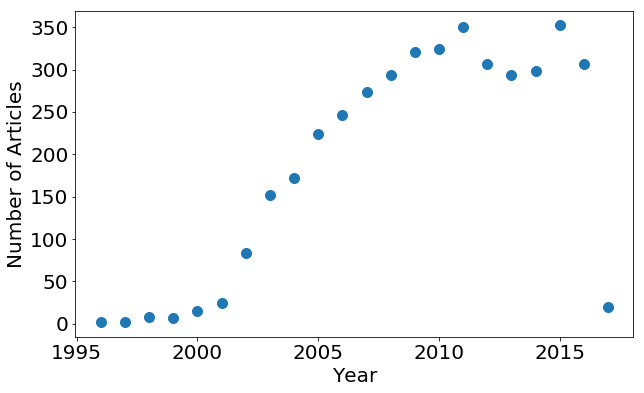

In [54]:
fig=plt.figure(figsize=(10, 6))
plt.plot(pub_year.keys(), pub_year.values(),'.', markersize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of Articles', fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.show()

## Conclusions

We can conclude from the plot that the topic of optical lattice became a hot topic in the mid-2000s and appears to have plateaued at around 2010.

Furthermore, it is straightforward to search for other keywords of interest and make a similar to plot to explore trending topics in physics.